# Predict hiking times based on statistics from GPX files

We attempt to predict the walking times (or more precisely the moving times) for hikes based on statistics extracted from GPX files. Using personal GPX records as input, the outputs are personalized as well.

The code is based on the `basic_regression.ipynb` notebook from [Tensorflow tutorials](https://github.com/tensorflow/docs/blob/r1.13/site/en/tutorials/keras/basic_regression.ipynb).

We use the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.callbacks as callbacks

import numpy as np

import utils

print(tf.__version__)

2.2.0


### Load data
Load the dataset that was prepared by running `prepareData.py`.

In [3]:
dataset = 'hiking_data.csv'

Convert data to a pandas dataframe:

In [4]:
import gpxStats

column_names = gpxStats.GpxStats.getHeader()
raw_dataset = pd.read_csv(dataset, header=0,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

raw_dataset.pop('Name')
# raw_dataset.pop('MaxSpeed')

dataset = raw_dataset.copy()
dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill
7078,17.293649,17.294805,15.0,15.0,0.0,0.000000,0.200012
7079,4.907396,4.911470,6.0,6.0,0.0,0.200012,0.000000
7080,94.032373,94.035776,54.0,54.0,0.0,0.800049,0.000000
7081,3.094057,3.195820,3.0,3.0,0.0,0.800049,0.000000
7082,3.349462,3.443687,3.0,3.0,0.0,0.800049,0.000000


### Clean the data

Inspect dataset and see if there are unknown values:

In [5]:
dataset.isna().sum()

Length2d         0
Length3d         0
Duration         0
MovingTime       0
StoppedTime      0
TotalUphill      0
TotalDownhill    0
dtype: int64

The data looks fine, so we do not have to clean it.

In [6]:
dataset = dataset.dropna()

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the data set.

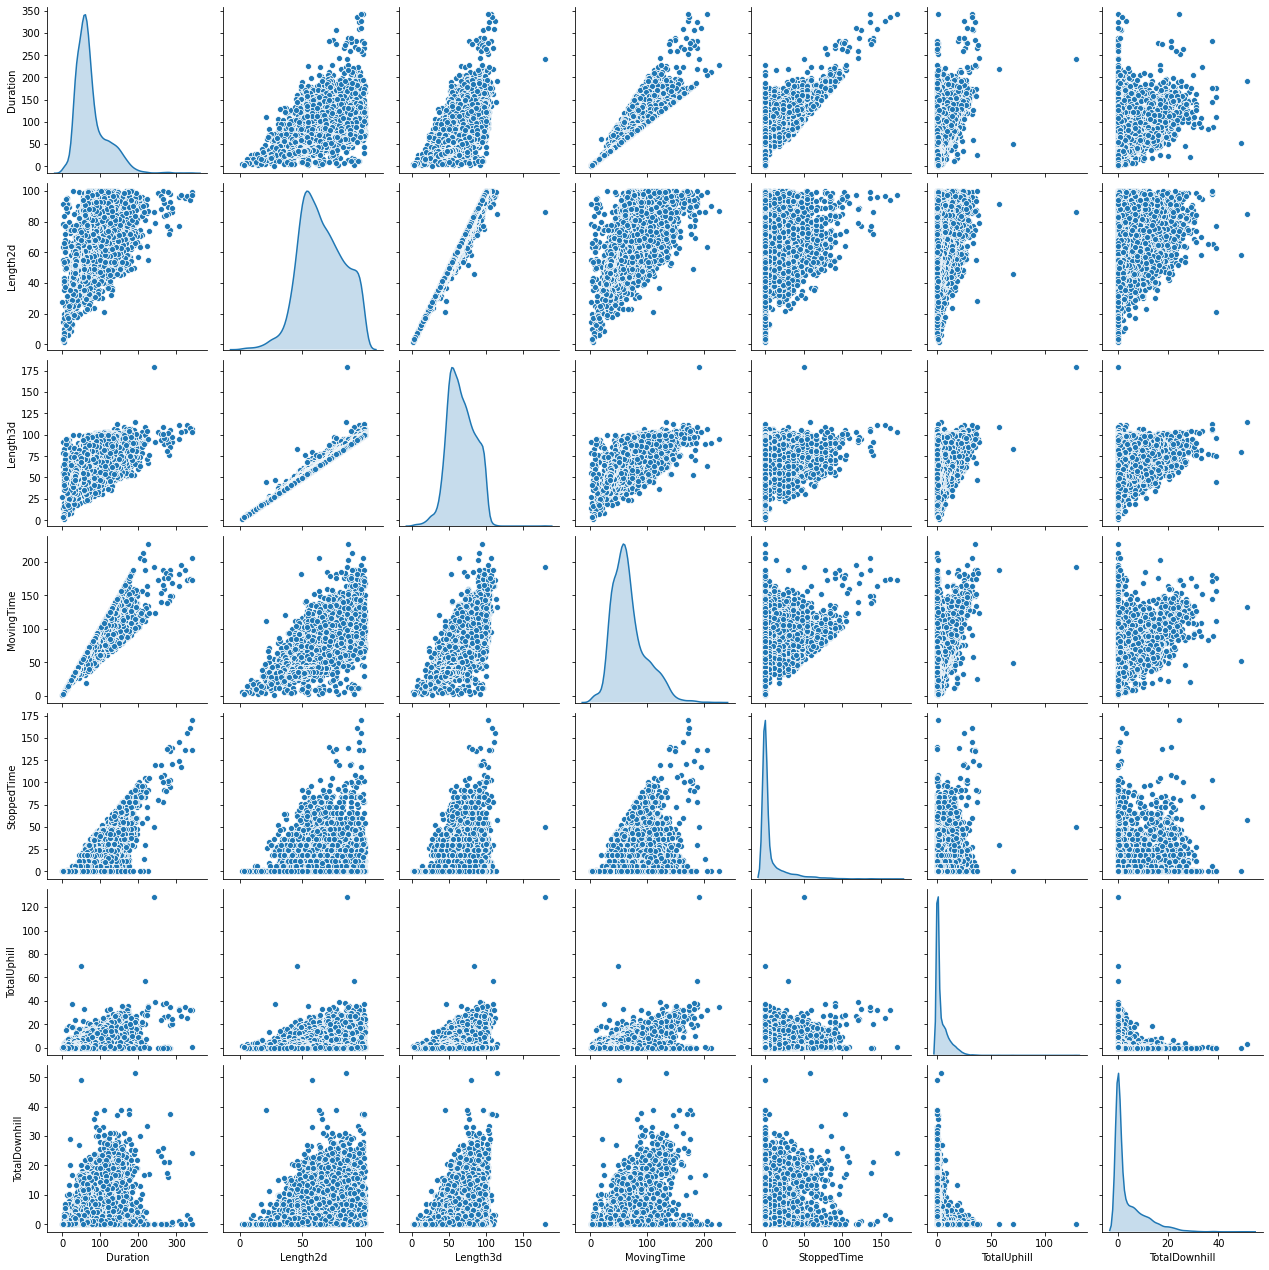

In [7]:
sns.pairplot(dataset[["Duration", "Length2d", "Length3d", "MovingTime", "StoppedTime", "TotalUphill", "TotalDownhill"]], diag_kind="kde")

Also look at the overall statistics:

In [8]:
dataset_stats = dataset.describe()
dataset_stats.pop("MovingTime")
dataset_stats.pop("StoppedTime")
dataset_stats.pop("Duration")
dataset_stats = dataset_stats.transpose()
dataset_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,7083.0,65.702032,17.577255,1.556419,52.710782,64.040397,79.121873,99.999161
Length3d,7083.0,66.960240,17.962236,1.965279,53.599333,65.269739,80.610896,179.074604
TotalUphill,7083.0,4.090948,6.300522,0.000000,0.000000,0.820007,6.399963,129.000000
TotalDownhill,7083.0,4.140287,6.135593,0.000000,0.000000,0.800061,6.599976,51.500000


The `"Name"` column does not contain information about the walking time, so we dropped it. `"MaxSpeed"` does not contain useful information for our purpose, and seems to be uncorrelated with `"MovingTime"`, `"StoppedTime"` as well as `"Duration"`.

In [9]:
dataset.tail()

,Length2d,Length3d,Duration,MovingTime,StoppedTime,TotalUphill,TotalDownhill
7078,17.293649,17.294805,15.0,15.0,0.0,0.000000,0.200012
7079,4.907396,4.911470,6.0,6.0,0.0,0.200012,0.000000
7080,94.032373,94.035776,54.0,54.0,0.0,0.800049,0.000000
7081,3.094057,3.195820,3.0,3.0,0.0,0.800049,0.000000
7082,3.349462,3.443687,3.0,3.0,0.0,0.800049,0.000000


### Split the data into train and test datasets

Now we split the dataset into a training set and a test set. We will use the test set in the final evaluation of our model.

In [10]:
train_dataset = dataset.sample(frac=0.8) # , random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Obtain statistics about the training set for normalization:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MovingTime")
train_stats.pop("StoppedTime")
train_stats.pop("Duration")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Length2d,5666.0,65.752038,17.597520,1.556419,52.775126,64.100335,79.206074,99.999161
Length3d,5666.0,67.009803,18.002413,1.965279,53.668790,65.418640,80.695670,179.074604
TotalUphill,5666.0,4.107835,6.308173,0.000000,0.000000,0.820053,6.400024,129.000000
TotalDownhill,5666.0,4.121868,6.164987,0.000000,0.000000,0.799988,6.599976,51.500000


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that we will train the model to predict.

In [12]:
# train_dataset.pop('StoppedTime')

label_columns = ['MovingTime', 'StoppedTime', 'Duration']
train_labels_data = []
test_labels_data = []

for col_name in label_columns:
    train_labels_data.append(train_dataset.pop(col_name))
    test_labels_data.append(test_dataset.pop(col_name))

train_labels = pd.concat(train_labels_data, axis=1)
train_labels.sort_index(inplace=True)
test_labels = pd.concat(test_labels_data, axis=1)
test_labels.sort_index(inplace=True)

train_dataset.sort_index(inplace=True)

In [13]:
print(train_dataset.tail())
print(train_labels.tail())

       Length2d   Length3d  TotalUphill  TotalDownhill
7077  64.177861  64.179107     0.399963       0.000000
7078  17.293649  17.294805     0.000000       0.200012
7079   4.907396   4.911470     0.200012       0.000000
7080  94.032373  94.035776     0.800049       0.000000
7082   3.349462   3.443687     0.800049       0.000000
      MovingTime  StoppedTime  Duration
7077        24.0          0.0      24.0
7078        15.0          0.0      15.0
7079         6.0          0.0       6.0
7080        54.0          0.0      54.0
7082         3.0          0.0       3.0


### Normalize the data

The statistics about `train_stats` in the above block shows a wide variation of ranges for all features. Although a model *might* converge without feature normalization, the latter usually improves convergence properties.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset and the pretraining data set. We need to do that to project the test dataset into the same distribution as the one the model has been trained on.

In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

with open('train_stats.csv', 'w') as csvfile:
    train_stats.to_csv(csvfile, sep=' ')

`normed_train_data` is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model. This includes the test dataset as well as input during inference. Thus we need to save the normalization numbers together with the model.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, for convencience.

In [29]:
learning_rate = 0.001

def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(len(train_labels.keys()))
    ])

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

How did we specify the architecture of the model?

The architecture is chosen such that we can reproduce esimates for walking times from a standard formula that is implemented in the function `compute_standard_walking_time` in `utils.py`. 

In principle, we would not need pretraining. However, as our set of GPX tracks from hiking is quite small, pretraining is helpful for designing the model and for making training more smooth.

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `4` examples from the training data and call `model.predict` on it.

In [31]:
example_batch = normed_train_data[:4]
example_result = model.predict(example_batch)
example_result

array([[-0.01366416,  0.04783523, -0.13824129],
       [-0.00830083,  0.06250581, -0.15668963],
       [ 0.0067994 , -0.21977109, -0.11108507],
       [-0.01390833,  0.03629827, -0.05484372]], dtype=float32)

## Some helper functions used later during training

In [32]:
# Plot the dependency of errors on epoch
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MovingTime]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    plt.yscale('log')
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MovingTime^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'], label = 'Val Error')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Train the model

Train the model for up to 500 epochs with the training set, and record the training and validation accuracy in the `history` object.

In [33]:
EPOCHS = 500

# def learning_rate_schedule(epoch):
#     return 0.001 / 2**(epoch // 50)

# lr_schedule = callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=20, min_lr=0.01*learning_rate)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40, verbose=1, 
                                                  restore_best_weights=False)

callbacks = [reduce_lr, early_stopping]


history = model.fit(normed_train_data.values, train_labels.values,
                    epochs=EPOCHS, validation_split = 0.2, verbose=1,
                    callbacks=callbacks)

Epoch 1/500
142/142 [==============================] - 0s 2ms/step - loss: 3056.4780 - mean_absolute_error: 40.5339 - mean_squared_error: 3056.4780 - val_loss: 271.1783 - val_mean_absolute_error: 10.8996 - val_mean_squared_error: 271.1783 - lr: 0.0010
Epoch 2/500
142/142 [==============================] - 0s 1ms/step - loss: 602.2924 - mean_absolute_error: 16.4791 - mean_squared_error: 602.2924 - val_loss: 378.6650 - val_mean_absolute_error: 15.1684 - val_mean_squared_error: 378.6650 - lr: 0.0010
Epoch 3/500
142/142 [==============================] - 0s 1ms/step - loss: 563.9786 - mean_absolute_error: 16.0037 - mean_squared_error: 563.9786 - val_loss: 320.4894 - val_mean_absolute_error: 14.1176 - val_mean_squared_error: 320.4894 - lr: 0.0010
Epoch 4/500
142/142 [==============================] - 0s 1ms/step - loss: 548.5265 - mean_absolute_error: 15.8078 - mean_squared_error: 548.5265 - val_loss: 263.9006 - val_mean_absolute_error: 12.6859 - val_mean_squared_error: 263.9006 - lr: 0.001

Epoch 34/500
142/142 [==============================] - 0s 1ms/step - loss: 486.8031 - mean_absolute_error: 14.8964 - mean_squared_error: 486.8031 - val_loss: 244.9484 - val_mean_absolute_error: 12.3744 - val_mean_squared_error: 244.9484 - lr: 0.0010
Epoch 35/500
142/142 [==============================] - 0s 1ms/step - loss: 487.3404 - mean_absolute_error: 14.8712 - mean_squared_error: 487.3404 - val_loss: 218.1668 - val_mean_absolute_error: 11.3523 - val_mean_squared_error: 218.1668 - lr: 0.0010
Epoch 36/500
142/142 [==============================] - 0s 1ms/step - loss: 486.2159 - mean_absolute_error: 14.8462 - mean_squared_error: 486.2159 - val_loss: 262.9740 - val_mean_absolute_error: 12.9269 - val_mean_squared_error: 262.9740 - lr: 0.0010
Epoch 37/500
142/142 [==============================] - 0s 1ms/step - loss: 484.3138 - mean_absolute_error: 14.8021 - mean_squared_error: 484.3138 - val_loss: 223.2515 - val_mean_absolute_error: 11.6070 - val_mean_squared_error: 223.2515 - lr: 0.0

Visualize the model's training progress using the stats stored in the `history` object.

In [34]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr,epoch
60,462.889130,14.468295,462.889130,267.516327,13.249914,267.516327,0.0005,60
61,462.379730,14.475554,462.379730,221.459488,11.425019,221.459488,0.0005,61
62,460.336578,14.399461,460.336578,232.487152,11.735948,232.487152,0.0005,62
63,461.416290,14.406450,461.416290,261.243286,12.862925,261.243286,0.0005,63
64,460.220184,14.434628,460.220184,226.556534,11.538188,226.556534,0.0005,64


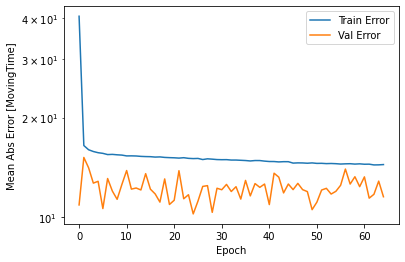

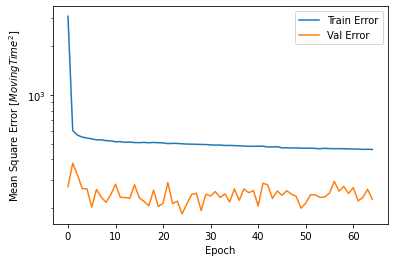

In [35]:
plot_history(history)

As our data set of real GPX tracks is very small, the optimal choice of the epoch for ending training depends on the distribution of tracks between training, validation and testing data. The above choice led to quite stable results.


### Make predictions

Finally, predict walking time values using data in the testing set:

In [36]:
standard_estimate = []

for index, data in test_dataset.iterrows():
    standard_estimate.append(utils.compute_standard_walking_time(data['Length2d'],
                                                                 data['TotalUphill'],
                                                                 data['TotalDownhill']))
    
moving_stopped_duration_data_list = []
for index, data in test_labels.iterrows():
    moving_stopped_duration_data_list.append([data['MovingTime'], data['StoppedTime'], data['Duration']])
moving_stopped_duration_data = np.array(moving_stopped_duration_data_list)
moving_stopped_duration_data = np.transpose(moving_stopped_duration_data)


test_predictions = model.predict(normed_test_data)
test_predictions = np.transpose(test_predictions)

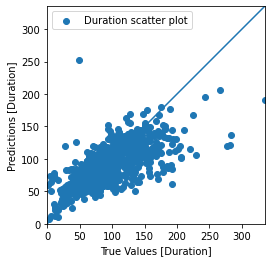

In [37]:
plt.scatter(moving_stopped_duration_data[2], test_predictions[2], label='Duration scatter plot')
max_val = max([max(moving_stopped_duration_data[2]), max(test_predictions[2])])
plt.xlabel('True Values [Duration]')
plt.ylabel('Predictions [Duration]')
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

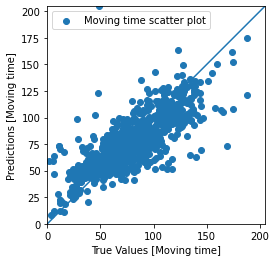

In [38]:
plt.scatter(moving_stopped_duration_data[0], test_predictions[0], label='Moving time scatter plot')
max_val = max([max(moving_stopped_duration_data[0]), max(test_predictions[0])])
plt.xlabel('True Values [Moving time]')
plt.ylabel('Predictions [Moving time]')
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

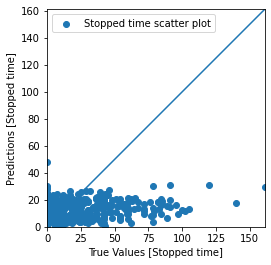

In [39]:
plt.scatter(moving_stopped_duration_data[1], test_predictions[1], label='Stopped time scatter plot')
max_val = max([max(moving_stopped_duration_data[1]), max(test_predictions[1])])
plt.xlabel('True Values [Stopped time]')
plt.ylabel('Predictions [Stopped time]')
plt.axis('equal')
plt.axis('square')
plt.legend()
plt.xlim([0, max_val])
plt.ylim([0, max_val])
_ = plt.plot([0, max_val], [0, max_val])

It looks like our model predicts reasonably well, as the results should be as close to the diagonal as possible. Let's take a look at the error distribution.

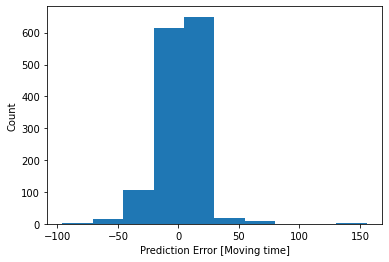

In [40]:
error = test_predictions[0] - np.transpose(np.array(test_labels))[0]
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Moving time]")
_ = plt.ylabel("Count")

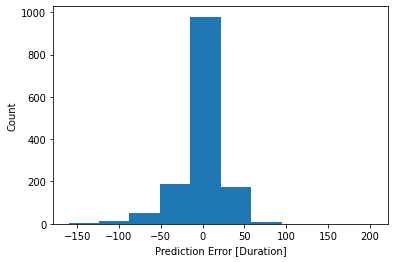

In [41]:
error = test_predictions[2] - np.transpose(np.array(test_labels))[2]
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error [Duration]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

If our model yielded a reasonable training, validation and testing performance, we can export it here for future use:

In [28]:
model.save('model_hikingTimePrediction.h5')

## Conclusion

This notebook presents the training of an algorithm for predicting moving and stopping times as well as total duration for hiking (but it can also be applied to many other outdoor activities). We accomplished this by treating it as a regression problem.